# Step5: Stock Portfolio Optimization Models

---
**What does this notebook do?**
- After selecting the top 5 stocks from each period and each prediction models to form portfolio in step4
- This notebook will build up portfolio optimization algorithms
- And run the algorithms for each portfolio to optimize the weight of each stock in portfolio
- It also builds up algorithms in functions that can be easily used in the .py files in [Research-Program folder](../Research-Program)
- Finally, record the optimal weight, Sharpe ratio, cumulative return in file

**To-Do List**
1. Build up functions to construct the portfolios of a given stock list
2. Build up portfolio optimization functions
| Portfolio Optimization Algorithms | Used Packages | 
| :--- | :--- |
| Equal-Weighted Portfolio | hard-coded | 
| Mean-Variance Optimization | PyPortfolioOpt |
| Hierarchical Risk Parity Optimization | PyPortfolioOpt |
| K-Mean Clustering based Mean-Variance Optimization | scikit-learn, PyPortfolioOpt | 


3. Create 4 different periods for research study
    | Time Period Group | Specific Time Range | 
    | --- | --- |
    | Overall time period | 2012-01-01 to 2022-01-01 | 
    | Pre Covid time period | 2012-01-01 to 2020-01-09 |
    | Covid time period | 2022-01-09 to 2022-01-01 |
    | Pre Covid Test time period | 2018-01-09 to 2020-01-01 | 

4. Output the functions to .py programs to run and store the results in table / figures
---

## Breakdown Functions
- This section contains all the reuseable content in all stock prediction algorithms

In [1]:
def get_stock_code_company_name(stock_code):
    """
    This function returns the corresponding company name
    of a certain stock code
    """
    import pandas as pd
    all_stock_data = pd.read_csv('../DataSource/research_use_39_stocks.csv')
    stock_code_df = all_stock_data[all_stock_data['Stock Code'] == stock_code]
    company_name = stock_code_df.iloc[0]["Company Name"]
    return company_name

In [2]:
def get_selected_stocks_df(stock_code_list, start_date, end_date):
    """
    This function returns a dataframe containing all the stocks
    needed in one portfolio with their historical prices
    """
    import pandas as pd
    from functools import reduce
    
    stock_df_list = []
    
    print("Start extracting all stocks ......")
    
    for stock_code in stock_code_list:
        data_file_location = '../DataSource/StockData/' + stock_code + ".csv"
        df = pd.read_csv(data_file_location)[["date", "close"]]
        df = df[(df['date']>=start_date) & (df['date']<=end_date)]
        
        company_name = get_stock_code_company_name(stock_code)
        stock_name = stock_code + "-" + company_name
        
        df = df.rename(columns={"close": stock_name})
        stock_df_list.append(df)
        
    df_merged = reduce(lambda left,right: pd.merge(left,right,on=['date'],how='outer'), stock_df_list)
    
    df_merged = df_merged.dropna()
    df_merged['date'] = pd.to_datetime(df_merged['date'])
    df_merged = df_merged.set_index('date')
    print(f"Finish outputing {len(stock_code_list)} stocks: {[str(i) for i in stock_code_list]}" )
    return df_merged

In [3]:
# Examples of running get_selected_stocks_df function
df = get_selected_stocks_df(["HK.00700", "HK.01299", "HK.00005", "HK.00669"], "2012-01-01", "2016-01-01")
df.head()

Start extracting all stocks ......
Finish outputing 4 stocks: ['HK.00700', 'HK.01299', 'HK.00005', 'HK.00669']


,HK.00700-TENCENT,HK.01299-AIA,HK.00005-HSBC HOLDINGS,HK.00669-TECHTRONIC IND
date,,,,
2012-01-26,28.991828,18.0468,32.83861,2.6775
2012-01-27,28.681236,18.0968,33.43861,2.3675
2012-01-30,29.283008,17.4968,32.78861,2.0675
2012-01-31,30.311844,17.5968,32.88861,2.1375
2012-02-01,29.147124,17.9468,32.63861,2.1275


In [4]:
def add_portfolio_return(data, portfolio_name_list, portfolio_weight_list):
    """
    This function adds the portfolio return based on 
    the weight of each stock and their historical price
    """
    import numpy as np
    import pandas as pd
    sub_data = data.copy()
    sub_data.loc[:, portfolio_name_list] *= np.array(portfolio_weight_list)
    data['portfolio_return'] = sub_data[portfolio_name_list].sum(axis=1)
    return data

In [5]:
def plot_portfolio_with_stocks(df, stock_list, period_name, model_name, prediction_model):
    """
    This function plots all the stocks price history 
    with the new weighted portfolio price history
    """
    from matplotlib import pyplot as plt
    from matplotlib import style
    import matplotlib.ticker as ticker

    # Plot the original Stock Price and Model Prediction
    plt.style.use('fivethirtyeight')
    fig, ax = plt.subplots(figsize=(18,8))

    ax.plot(df, label=df.columns)

    # Adjust the labels and ticks for the plot
    title = f"{period_name}\n - {model_name}\n- {prediction_model} Prediction"

    xlabel = f"Stock Date Period: {str(df.index[0]).split(' ')[0]} - {str(df.index[-1]).split(' ')[0]}"
    ylabel = "Close Stock Price (HKD)"

    ax.set_title(title,fontsize=25, pad=20)
    ax.set_xlabel(xlabel, fontsize=18,fontstyle='oblique', labelpad=15)
    ax.set_ylabel(ylabel, fontsize=18,fontstyle='oblique', labelpad=15)
    ax.legend(fontsize=14, facecolor='white')

    ax.xaxis.set_major_locator(ticker.AutoLocator())
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())

    figure_file_name = f"[{period_name}]-[{model_name}]-[{prediction_model}]]"
    figure_file_location = "../Results/PortfolioResultFigures/" + figure_file_name + ".png"
    plt.savefig(figure_file_location, bbox_inches='tight')
    print("\nSave figure in the " + figure_file_location)

# Portfolio Optimization Functions

---
**How is the Portfolio Optimization Algorithm built up?**
- Equal-Weighted Portfolio uses the hard-code method
- The other algorithms all use the `PyPortfolioOpt` package, more information can be found
    - [PyPortfolioOpt Official Documentation](https://pyportfolioopt.readthedocs.io/en/latest/)
    - [PyPortfolioOpt Official Github Repository](https://github.com/robertmartin8/PyPortfolioOpt)
---

## Equal-Weighted Portfolio

In [6]:
def equal_weight_portfolio(stock_list, start_date, end_date, period_name, prediction_model):
    """
    This function builds up a equal-weighted portfolio based on stock list and the date period,
    and it returns the portfolio weight, annual sharpe ratio, cumulative return of the portfolio
    """
    import pandas as pd
    import numpy as np
    # Get the stock portfolios
    df = get_selected_stocks_df(stock_list, start_date, end_date)
    # Calculate the equal weight
    equal_weight = 1 / len(df.columns)
    weight = dict({stock:equal_weight for stock in df.columns})
    print("Portfolio Weight:" + str(weight))

    # Calculate the Sharpe ratio
    portfolio_name, portfolio_weight = list(weight.keys()), list(weight.values())
    log_return = np.sum(np.log(df/df.shift())*portfolio_weight, axis=1)
    sharpe_ratio = log_return.mean()/log_return.std()

    annual_sharpe_ratio = sharpe_ratio*252**.5
    print("Portfolio Sharpe Ratio: " + str(annual_sharpe_ratio))
    
    df = add_portfolio_return(df, portfolio_name, portfolio_weight)

    start_date_portfolio_value, end_date_portfolio_value = df['portfolio_return'][0], df['portfolio_return'][-1]
    
    plot_portfolio_with_stocks(df, stock_list, period_name, "Equal Weighted Optimization", prediction_model)
    
    return weight, annual_sharpe_ratio, start_date_portfolio_value, end_date_portfolio_value, end_date_portfolio_value-start_date_portfolio_value

Start extracting all stocks ......
Finish outputing 5 stocks: ['HK.00700', 'HK.02020', 'HK.02313', 'HK.00669', 'HK.02331']
Portfolio Weight:{'HK.00700-TENCENT': 0.2, 'HK.02020-ANTA SPORTS': 0.2, 'HK.02313-SHENZHOU INTL': 0.2, 'HK.00669-TECHTRONIC IND': 0.2, 'HK.02331-LI NING': 0.2}
Portfolio Sharpe Ratio: 0.486729068913587


/Users/maxma/mambaforge/lib/python3.9/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)



Save figure in the ../Results/PortfolioResultFigures/[All Time Period]-[Equal Weighted Optimization]-[Mean Average Prediction]].png


({'HK.00700-TENCENT': 0.2,
  'HK.02020-ANTA SPORTS': 0.2,
  'HK.02313-SHENZHOU INTL': 0.2,
  'HK.00669-TECHTRONIC IND': 0.2,
  'HK.02331-LI NING': 0.2},
 0.486729068913587,
 9.81101176,
 190.084016,
 180.27300423999998)

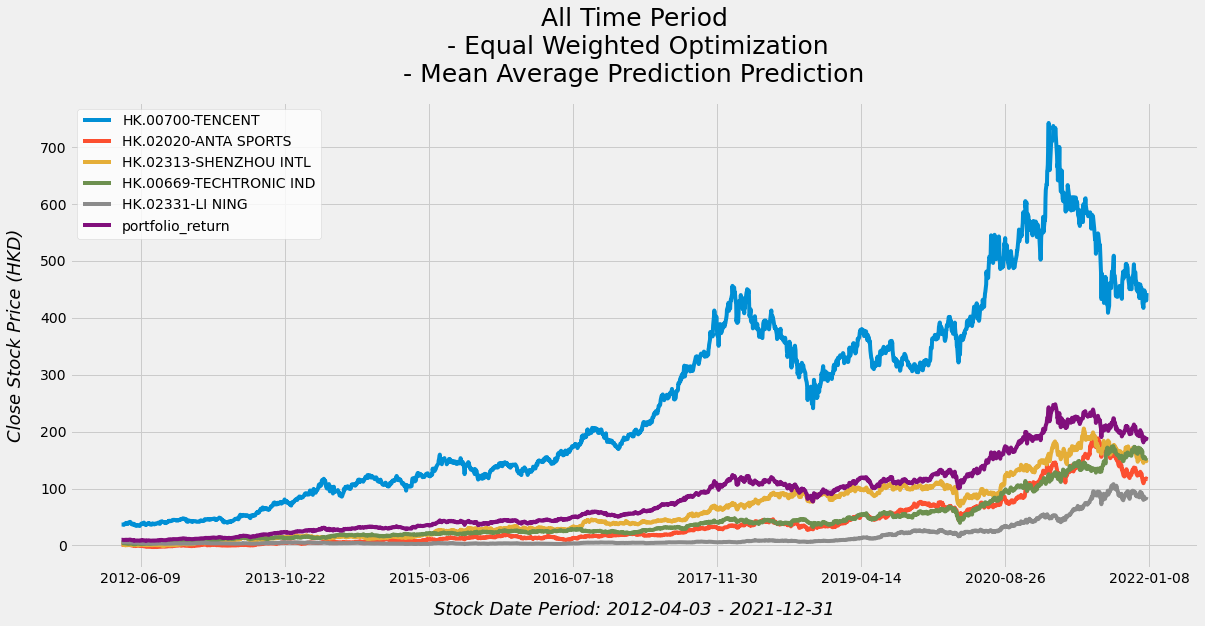

In [7]:
equal_weight_portfolio(['HK.00700', 'HK.02020', 'HK.02313', 'HK.00669', 'HK.02331'], "2012-01-01", "2022-01-01", "All Time Period", 'Mean Average Prediction')

## Mean-Variance Optimization

In [8]:
def mean_variance_portfolio(stock_list, start_date, end_date, model_name, period_name, prediction_model):
    """
    This function builds up a Mean-Variance Optimized portfolio based on stock list and the date period,
    and it returns the portfolio weight, annual sharpe ratio, cumulative return of the portfolio
    """
    import pandas as pd
    df = get_selected_stocks_df(stock_list, start_date, end_date)

    # Estimate the expected returns and covariance matrix from the historical data
    from pypfopt.expected_returns import mean_historical_return
    from pypfopt.risk_models import CovarianceShrinkage

    mu = mean_historical_return(df)
    S = CovarianceShrinkage(df).ledoit_wolf()

    # Mean-Variance Optimization: find the portfolio that maximises the Sharpe Ratio
    from pypfopt.efficient_frontier import EfficientFrontier

    ef = EfficientFrontier(mu, S)
    weights = ef.max_sharpe()
    cleaned_weights = ef.clean_weights()

    print("Portfolio Weight:" + str(dict(cleaned_weights)))

    # Print out the expected performance of the portfolio
    annual_sharpe_ratio = ef.portfolio_performance(verbose=True)[-1]

    weight = dict(cleaned_weights)

    portfolio_name, portfolio_weight = list(weight.keys()), list(weight.values())
    
    """
    Functions to plot the efficient frontier with Monte Carlo Simulation
    """
    # from pypfopt import CLA, plotting

    # n_samples = 50000
    # w = np.random.dirichlet(np.ones(len(mu)), n_samples)
    # rets = w.doat(mu)
    # stds = np.sqrt((w.T * (S @ w.T)).sum(axis=0))
    # sharpes = rets / stds

    # print("Sample portfolio returns:", rets)
    # print("Sample portfolio volatilities:", stds)

    # # Plot efficient frontier with Monte Carlo sim
    # ef = EfficientFrontier(mu, S)

    # fig, ax = plt.subplots(figsize=(10,6))
    # plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False)

    # # Find and plot the tangency portfolio
    # ef2 = EfficientFrontier(mu, S)
    # ef2.max_sharpe()
    # ret_tangent, std_tangent, _ = ef2.portfolio_performance()

    # # Plot random portfolios
    # ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

    # cla = CLA(mu, S)
    # cla.max_sharpe()
    # cla.portfolio_performance(verbose=True);
    # ax = plotting.plot_efficient_frontier(cla, showfig=False)

    # # Format
    # ax.set_title("Efficient Frontier with random portfolios for \nAll Time Period-LSTM Network Prediction", fontsize=17)
    # ax.legend(fontsize=12)
    # plt.show()

    df = add_portfolio_return(df, portfolio_name, portfolio_weight)

    start_date_portfolio_value, end_date_portfolio_value = df['portfolio_return'][0], df['portfolio_return'][-1]
    
    plot_portfolio_with_stocks(df, stock_list, period_name, model_name, prediction_model)
    return weight, annual_sharpe_ratio, start_date_portfolio_value, end_date_portfolio_value, end_date_portfolio_value-start_date_portfolio_value

Start extracting all stocks ......
Finish outputing 5 stocks: ['HK.00700', 'HK.02020', 'HK.02313', 'HK.00669', 'HK.02331']
Portfolio Weight:{'HK.00700-TENCENT': 0.22873, 'HK.02020-ANTA SPORTS': 0.05026, 'HK.02313-SHENZHOU INTL': 0.10692, 'HK.00669-TECHTRONIC IND': 0.36449, 'HK.02331-LI NING': 0.2496}
Expected annual return: 42.0%
Annual volatility: 215.0%
Sharpe Ratio: 0.19

Save figure in the ../Results/PortfolioResultFigures/[All Time Period]-[Mean-Variance Optimization]-[Mean Average Prediction]].png


({'HK.00700-TENCENT': 0.22873,
  'HK.02020-ANTA SPORTS': 0.05026,
  'HK.02313-SHENZHOU INTL': 0.10692,
  'HK.00669-TECHTRONIC IND': 0.36449,
  'HK.02331-LI NING': 0.2496},
 0.18620851921894663,
 11.52684355356,
 201.1718703984,
 189.64502684484)

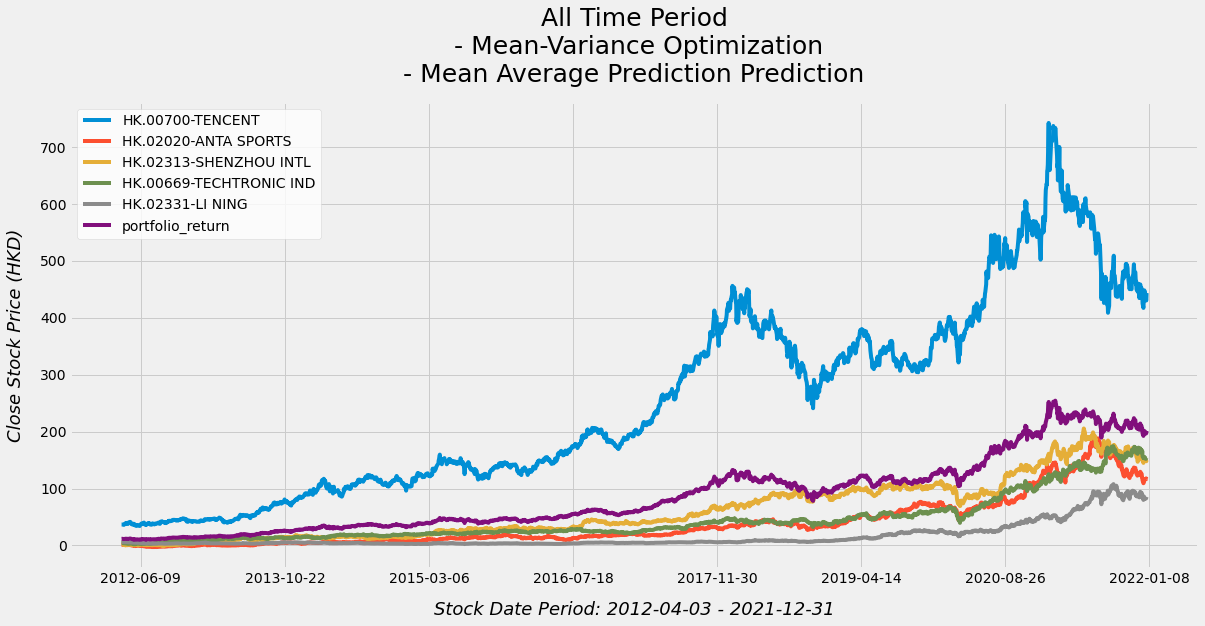

In [9]:
mean_variance_portfolio(['HK.00700', 'HK.02020', 'HK.02313', 'HK.00669', 'HK.02331'], "2012-01-01", "2022-01-01", "Mean-Variance Optimization", 'All Time Period', 'Mean Average Prediction')

## Hierarchical Risk Parity Optimization

In [10]:
def hierarchical_risk_parity_portfolio(stock_list, start_date, end_date, period_name, prediction_model):
    """
    This function builds up a Hierarchical Risk Parity optimized portfolio 
    based on stock list and the date period,
    and it returns the portfolio weight, annual sharpe ratio, cumulative return of the portfolio
    """
    df = get_selected_stocks_df(stock_list, start_date, end_date)

    # Import the packages and build up portfolio
    from pypfopt import expected_returns

    rets = expected_returns.returns_from_prices(df)

    from pypfopt import HRPOpt
    hrp = HRPOpt(rets)
    hrp.optimize()
    weights = hrp.clean_weights()

    # from pypfopt import plotting
    # plotting.plot_dendrogram(hrp);

    # Print out the expected performance of the portfolio
    annual_sharpe_ratio = hrp.portfolio_performance(verbose=True)[-1]

    weight = dict(weights)

    portfolio_name, portfolio_weight = list(weight.keys()), list(weight.values())

    df = add_portfolio_return(df, portfolio_name, portfolio_weight)

    start_date_portfolio_value, end_date_portfolio_value = df['portfolio_return'][0], df['portfolio_return'][-1]
    
    plot_portfolio_with_stocks(df, stock_list, period_name, 'Hierarchical Risk Parity Optimization', prediction_model)
    
    return weight, annual_sharpe_ratio, start_date_portfolio_value, end_date_portfolio_value, end_date_portfolio_value-start_date_portfolio_value

Start extracting all stocks ......
Finish outputing 5 stocks: ['HK.00700', 'HK.02020', 'HK.02313', 'HK.00669', 'HK.02331']
Expected annual return: 38.9%
Annual volatility: 30.0%
Sharpe Ratio: 1.23

Save figure in the ../Results/PortfolioResultFigures/[All Time Period]-[Hierarchical Risk Parity Optimization]-[Mean Average Prediction]].png


({'HK.00700-TENCENT': 0.50197,
  'HK.02020-ANTA SPORTS': 0.0005,
  'HK.02313-SHENZHOU INTL': 0.00124,
  'HK.00669-TECHTRONIC IND': 0.26705,
  'HK.02331-LI NING': 0.22924},
 1.230576862628777,
 20.847352273992005,
 283.81444905760003,
 262.96709678360804)

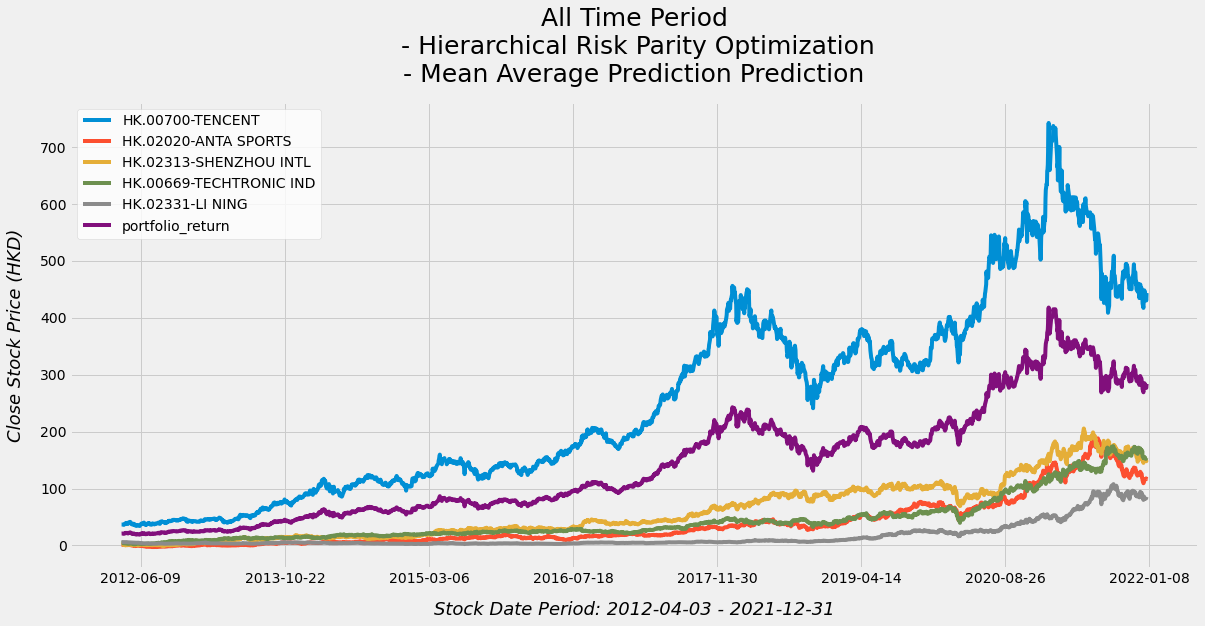

In [11]:
hierarchical_risk_parity_portfolio(['HK.00700', 'HK.02020', 'HK.02313', 'HK.00669', 'HK.02331'], "2012-01-01", "2022-01-01", "All Time Period", 'Mean Average Prediction')

## K-Mean Clustering based Mean-Variance Optimization

In [12]:
def kmean_mean_variance(stock_list, start_date, end_date, period_name, prediction_model): 
    """
    This function builds up a K-Mean Clustering based Mean-Variance optimized portfolio 
    based on stock list and the date period,
    and it returns the portfolio weight, annual sharpe ratio, cumulative return of the portfolio
    """
    # Import the packages from scikit-learn and the Mean-Variance Optimization function
    import pandas as pd
    import numpy as np
    from sklearn.cluster import KMeans
    import matplotlib.pyplot as plt

    df = get_selected_stocks_df(stock_list, start_date, end_date)
    
    # Calculate the returns and variances for the portfolio
    daily_returns = df.pct_change()
    annual_mean_returns = daily_returns.mean() * 222
    annual_return_variance = daily_returns.var() * 222

    df2 = pd.DataFrame(df.columns, columns=['stock_symbols'])

    df2['returns'] = annual_mean_returns.values
    df2['variances'] = annual_return_variance.values

    # Use the Silquoutte Score method to select k - number of clusters
    from sklearn.metrics import silhouette_samples, silhouette_score

    # Build up K-Mean clusters based on returns and variances of each stock
    X = df2[['returns', 'variances']].values

    silhouette_avg = []
    for i in range(2, len(X)-1):
        kmeans_fit = KMeans(n_clusters = i).fit(X)
        silhouette_avg.append(silhouette_score(X, kmeans_fit.labels_))

    best_perform_num = silhouette_avg.index(max(silhouette_avg)) + 2

    kmeans = KMeans(n_clusters = best_perform_num).fit(X)
    labels = kmeans.labels_

    df2['cluster_labels'] = labels

    ## Plot the K-Mean Cluster plot
    # plt.scatter(X[:,0], X[:,1], c=labels, cmap='rainbow')
    # plt.title('K-Means Plot')
    # plt.xlabel('Returns')
    # plt.ylabel('Variances')
    # plt.show()

    cluster_group = df2['cluster_labels'].value_counts().idxmax()
    df3 = df2[df2['cluster_labels'] == cluster_group]
    chosen_stocks = df3['stock_symbols'].tolist()

    # Re-select the dataframe with same group, samiliar level of return-risk
    df = df[chosen_stocks]

    # Run the Mean-Variance Optimization function for the updated portfolio dataframe
    weight, annual_sharpe_ratio, start_date_portfolio_value, end_date_portfolio_value, cumulative_return = mean_variance_portfolio(stock_list, start_date, end_date, "K-Mean based Mean-Variance Optimization", period_name, prediction_model)

    return weight, annual_sharpe_ratio, start_date_portfolio_value, end_date_portfolio_value, cumulative_return

Start extracting all stocks ......
Finish outputing 5 stocks: ['HK.00700', 'HK.02020', 'HK.02313', 'HK.00669', 'HK.02331']
Start extracting all stocks ......
Finish outputing 5 stocks: ['HK.00700', 'HK.02020', 'HK.02313', 'HK.00669', 'HK.02331']
Portfolio Weight:{'HK.00700-TENCENT': 0.22873, 'HK.02020-ANTA SPORTS': 0.05026, 'HK.02313-SHENZHOU INTL': 0.10692, 'HK.00669-TECHTRONIC IND': 0.36449, 'HK.02331-LI NING': 0.2496}
Expected annual return: 42.0%
Annual volatility: 215.0%
Sharpe Ratio: 0.19

Save figure in the ../Results/PortfolioResultFigures/[All Time Period]-[K-Mean based Mean-Variance Optimization]-[Mean Average Prediction]].png


({'HK.00700-TENCENT': 0.22873,
  'HK.02020-ANTA SPORTS': 0.05026,
  'HK.02313-SHENZHOU INTL': 0.10692,
  'HK.00669-TECHTRONIC IND': 0.36449,
  'HK.02331-LI NING': 0.2496},
 0.18620851921894663,
 11.52684355356,
 201.1718703984,
 189.64502684484)

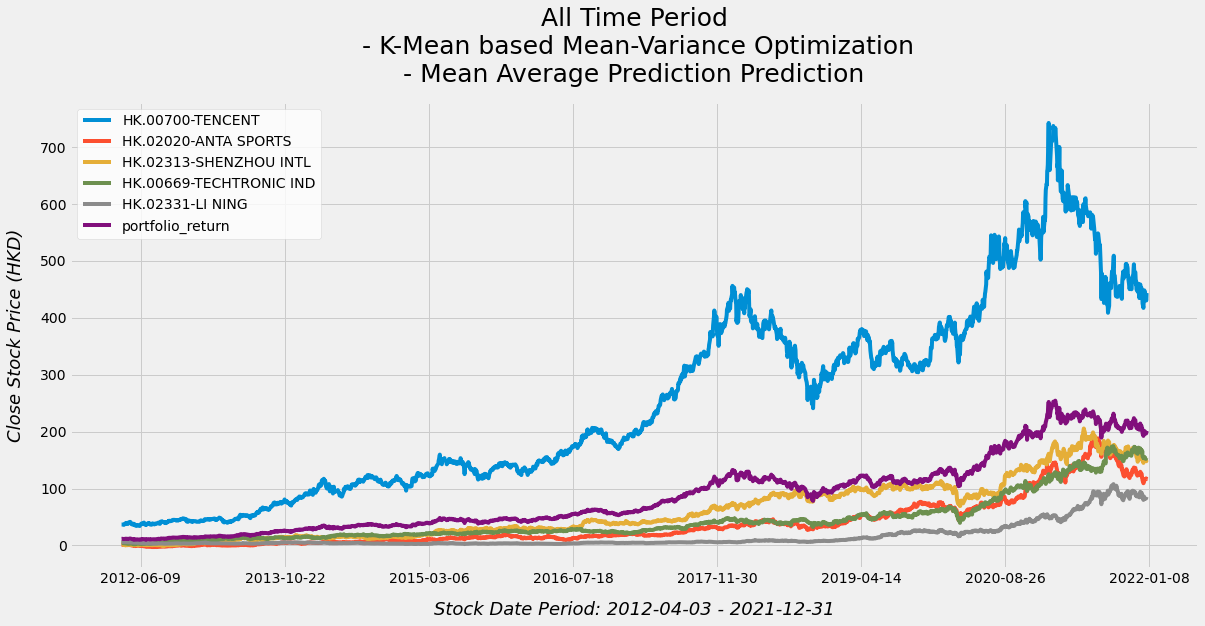

In [13]:
kmean_mean_variance(['HK.00700', 'HK.02020', 'HK.02313', 'HK.00669', 'HK.02331'], "2012-01-01", "2022-01-01", "All Time Period", 'Mean Average Prediction')

# Run All Portfolio Optimization Algorithms for All Portfolios

In [14]:
# Get all the portfolios from step4
import pandas as pd
pd.set_option('display.max_colwidth', None)
portfolio_input = pd.read_csv('../Results/StockPrediction/portfolio_input_all_period_top5.csv')
portfolio_input

,time period,model,portfolio stock input
0,all_time_results,Linear Regression,"['HK.00700', 'HK.02020', 'HK.00669', 'HK.02313', 'HK.02331']"
1,all_time_results,Support Vector Machine(linear),"['HK.00700', 'HK.02020', 'HK.01211', 'HK.02313', 'HK.00669']"
2,all_time_results,LSTM Network,"['HK.01299', 'HK.00016', 'HK.01109', 'HK.00011', 'HK.00006']"
3,all_time_results,Mean Average,"['HK.00700', 'HK.02020', 'HK.02313', 'HK.00669', 'HK.02331']"
4,covid_time_results,Linear Regression,"['HK.00700', 'HK.01211', 'HK.02020', 'HK.00388', 'HK.02331']"
5,covid_time_results,Support Vector Machine(linear),"['HK.01211', 'HK.00388', 'HK.00700', 'HK.02020', 'HK.02331']"
6,covid_time_results,LSTM Network,"['HK.00388', 'HK.02313', 'HK.02318', 'HK.02020', 'HK.02688']"
7,covid_time_results,Mean Average,"['HK.01211', 'HK.00700', 'HK.00388', 'HK.02020', 'HK.02331']"
8,pre_covid_time_results,Linear Regression,"['HK.00291', 'HK.00011', 'HK.02313', 'HK.01093', 'HK.01177']"
9,pre_covid_time_results,Support Vector Machine(linear),"['HK.02020', 'HK.00291', 'HK.01093', 'HK.00011', 'HK.01177']"


In [15]:
def get_all_portfolio_optimization_results_per_stock_list(time_period_results, prediction_model, stock_list):
    """
    This function builds up all four portfolio optimization models for one given portfolio
    and return a dataframe containing the time period, prediction model for the portfolio,
    as well as the optimal weight, sharpe ratio and cumulative return
    """
    import pandas as pd
    pd.set_option('display.max_colwidth', None)

    # Give the period time based on user input period name
    if time_period_results == 'all_time_results': 
        period_time = ('2012-01-01', '2022-01-01')
        period_name = 'All Time Period'
    elif time_period_results == 'pre_covid_time_results':
        period_time = ('2012-01-01', '2020-01-09')
        period_name = 'Pre Covid Time Period'
    elif time_period_results == 'covid_time_results':
        period_time = ('2020-01-09', '2022-01-01')
        period_name = 'Covid Time Period'
    elif time_period_results == 'pre_covid_test_time_results':
        period_time = ('2018-01-09', '2020-01-01')
        period_name = 'Pre Covid Test Time Period'

    result = pd.DataFrame(columns=['time_period', 'prediction_model', 'portfolio_input', 'portfolio_optimization_model',
                                   'model_weight','sharpe', 'start', 'end', 'cumulative_return'])

    (start_date, end_date) = period_time
    
    portfolio_optimization_model_list = []

    # Equal Weight Portfolio
    result_input_list = [time_period_results, prediction_model, stock_list, 'Equal Weight Portfolio']
    weight, annual_sharpe_ratio, start_date_portfolio_value, end_date_portfolio_value, cumulative_return = equal_weight_portfolio(stock_list, start_date, end_date, period_name, prediction_model)
    result_input_list.extend([weight, annual_sharpe_ratio, start_date_portfolio_value, end_date_portfolio_value, cumulative_return])
    result.loc[len(result)] = result_input_list
    # display(result)

    # Mean Variance Portfolio
    result_input_list = [time_period_results, prediction_model, stock_list, 'Mean Variance Portfolio']
    weight, annual_sharpe_ratio, start_date_portfolio_value, end_date_portfolio_value, cumulative_return = mean_variance_portfolio(stock_list, start_date, end_date, "Mean-Variance Optimization", period_name, prediction_model)
    result_input_list.extend([weight, annual_sharpe_ratio, start_date_portfolio_value, end_date_portfolio_value, cumulative_return])
    result.loc[len(result)] = result_input_list

    # Hierarchical Risk Parity Portfolio
    result_input_list = [time_period_results, prediction_model, stock_list, 'Hierarchical Risk Parity Portfolio']
    weight, annual_sharpe_ratio, start_date_portfolio_value, end_date_portfolio_value, cumulative_return = hierarchical_risk_parity_portfolio(stock_list, start_date, end_date, period_name, prediction_model)
    result_input_list.extend([weight, annual_sharpe_ratio, start_date_portfolio_value, end_date_portfolio_value, cumulative_return])
    result.loc[len(result)] = result_input_list


    # K-Mean Clustering based Mean-Variance Optimization
    result_input_list = [time_period_results, prediction_model, stock_list, 'K-Mean Clustering based Mean-Variance Optimization']
    weight, annual_sharpe_ratio, start_date_portfolio_value, end_date_portfolio_value, cumulative_return = kmean_mean_variance(stock_list, start_date, end_date, period_name, prediction_model)
    result_input_list.extend([weight, annual_sharpe_ratio, start_date_portfolio_value, end_date_portfolio_value, cumulative_return])
    result.loc[len(result)] = result_input_list

    return result

Start extracting all stocks ......
Finish outputing 5 stocks: ['HK.00700', 'HK.02020', 'HK.00669', 'HK.02313', 'HK.02331']
Portfolio Weight:{'HK.00700-TENCENT': 0.2, 'HK.02020-ANTA SPORTS': 0.2, 'HK.00669-TECHTRONIC IND': 0.2, 'HK.02313-SHENZHOU INTL': 0.2, 'HK.02331-LI NING': 0.2}
Portfolio Sharpe Ratio: 0.48672906891358714

Save figure in the ../Results/PortfolioResultFigures/[All Time Period]-[Equal Weighted Optimization]-[Linear Regression]].png
Start extracting all stocks ......


/Users/maxma/mambaforge/lib/python3.9/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


Finish outputing 5 stocks: ['HK.00700', 'HK.02020', 'HK.00669', 'HK.02313', 'HK.02331']
Portfolio Weight:{'HK.00700-TENCENT': 0.22873, 'HK.02020-ANTA SPORTS': 0.05026, 'HK.00669-TECHTRONIC IND': 0.36449, 'HK.02313-SHENZHOU INTL': 0.10692, 'HK.02331-LI NING': 0.2496}
Expected annual return: 42.0%
Annual volatility: 215.0%
Sharpe Ratio: 0.19

Save figure in the ../Results/PortfolioResultFigures/[All Time Period]-[Mean-Variance Optimization]-[Linear Regression]].png
Start extracting all stocks ......
Finish outputing 5 stocks: ['HK.00700', 'HK.02020', 'HK.00669', 'HK.02313', 'HK.02331']
Expected annual return: 38.9%
Annual volatility: 30.0%
Sharpe Ratio: 1.23

Save figure in the ../Results/PortfolioResultFigures/[All Time Period]-[Hierarchical Risk Parity Optimization]-[Linear Regression]].png
Start extracting all stocks ......
Finish outputing 5 stocks: ['HK.00700', 'HK.02020', 'HK.00669', 'HK.02313', 'HK.02331']
Start extracting all stocks ......
Finish outputing 5 stocks: ['HK.00700', 

,time_period,prediction_model,portfolio_input,portfolio_optimization_model,model_weight,sharpe,start,end,cumulative_return
0,all_time_results,Linear Regression,"[HK.00700, HK.02020, HK.00669, HK.02313, HK.02331]",Equal Weight Portfolio,"{'HK.00700-TENCENT': 0.2, 'HK.02020-ANTA SPORTS': 0.2, 'HK.00669-TECHTRONIC IND': 0.2, 'HK.02313-SHENZHOU INTL': 0.2, 'HK.02331-LI NING': 0.2}",0.486729,9.811012,190.084016,180.273004
1,all_time_results,Linear Regression,"[HK.00700, HK.02020, HK.00669, HK.02313, HK.02331]",Mean Variance Portfolio,"{'HK.00700-TENCENT': 0.22873, 'HK.02020-ANTA SPORTS': 0.05026, 'HK.00669-TECHTRONIC IND': 0.36449, 'HK.02313-SHENZHOU INTL': 0.10692, 'HK.02331-LI NING': 0.2496}",0.186209,11.526844,201.171870,189.645027
2,all_time_results,Linear Regression,"[HK.00700, HK.02020, HK.00669, HK.02313, HK.02331]",Hierarchical Risk Parity Portfolio,"{'HK.00700-TENCENT': 0.50197, 'HK.02020-ANTA SPORTS': 0.0005, 'HK.00669-TECHTRONIC IND': 0.26705, 'HK.02313-SHENZHOU INTL': 0.00124, 'HK.02331-LI NING': 0.22924}",1.230577,20.847352,283.814449,262.967097
3,all_time_results,Linear Regression,"[HK.00700, HK.02020, HK.00669, HK.02313, HK.02331]",K-Mean Clustering based Mean-Variance Optimization,"{'HK.00700-TENCENT': 0.22873, 'HK.02020-ANTA SPORTS': 0.05026, 'HK.00669-TECHTRONIC IND': 0.36449, 'HK.02313-SHENZHOU INTL': 0.10692, 'HK.02331-LI NING': 0.2496}",0.186209,11.526844,201.171870,189.645027


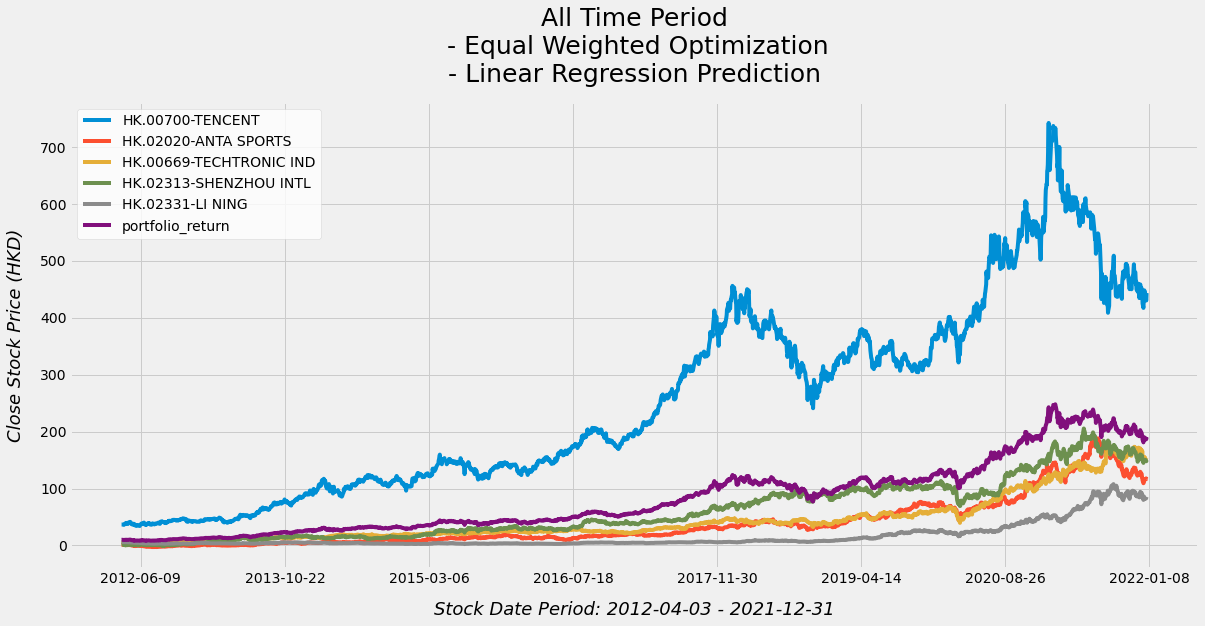

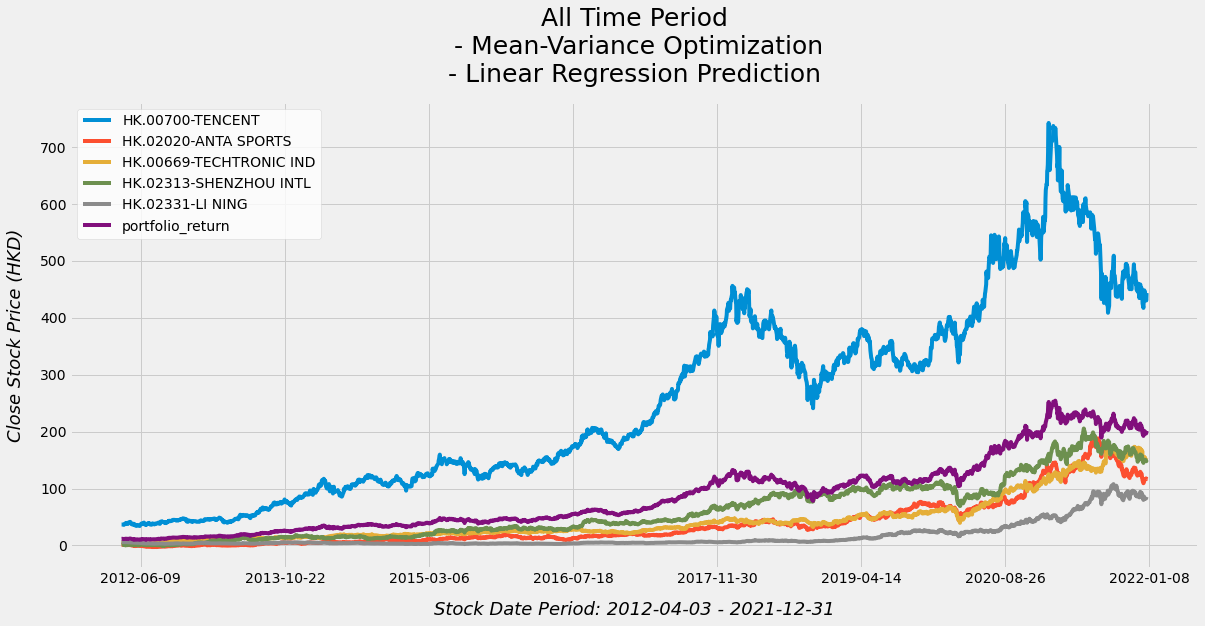

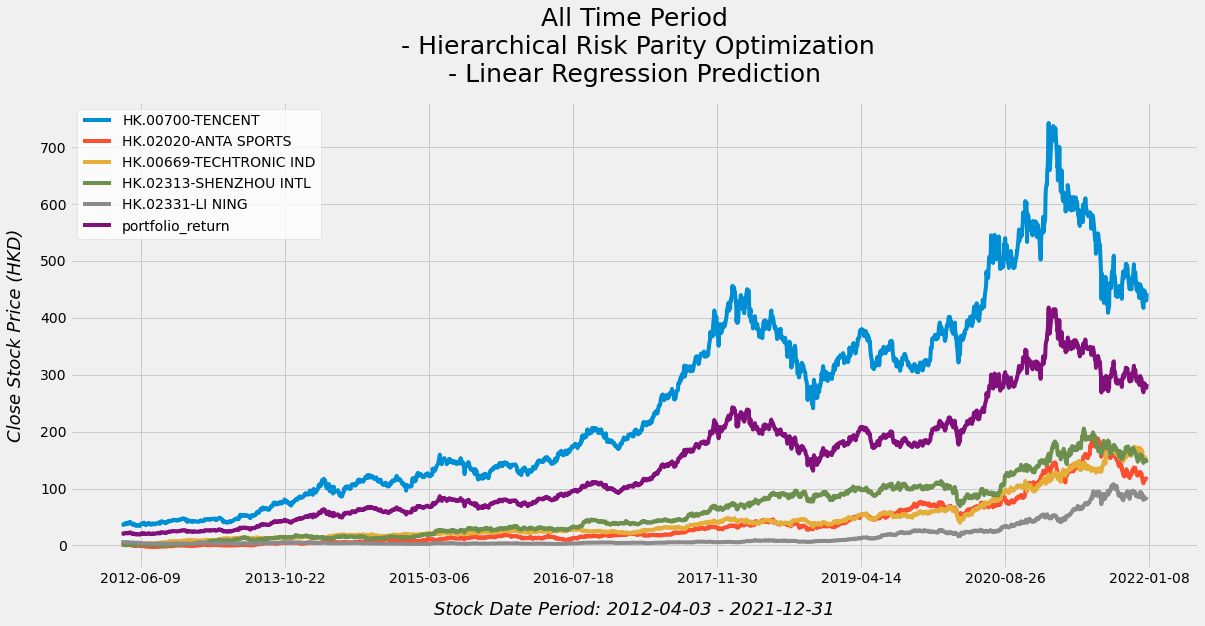

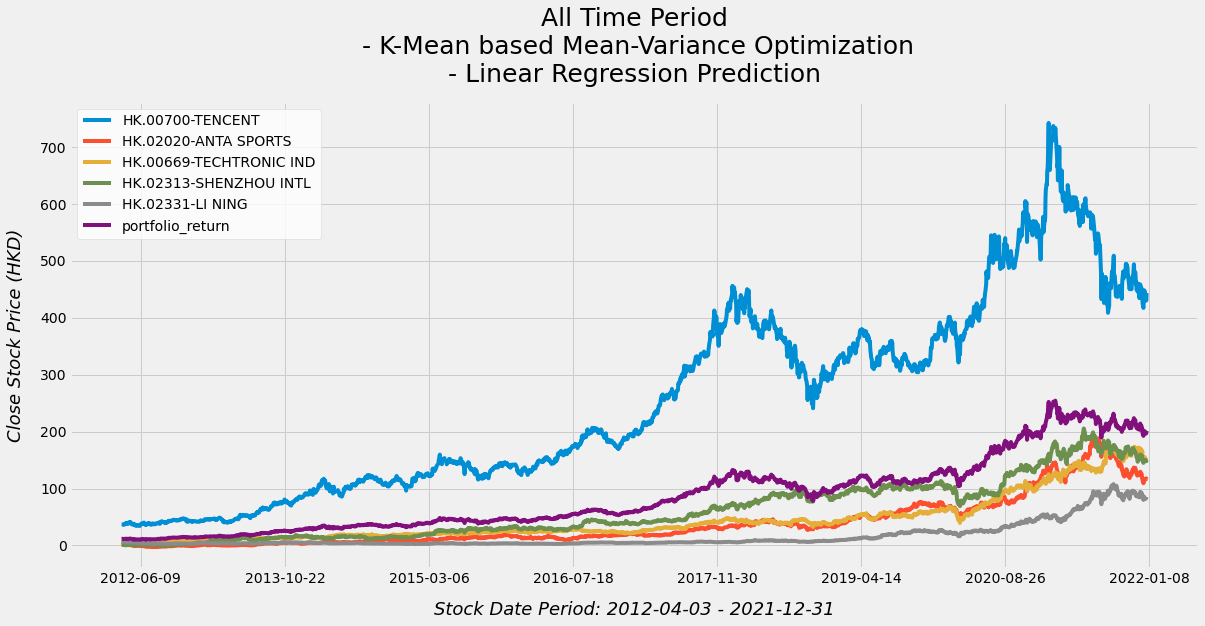

In [16]:
# Example of get_all_portfolio_optimization_results_per_stock_list function
# Result in all portfolio optimization models for one given portfolio(time period + prediction model)
time_period_results = portfolio_input.loc[0, 'time period']
prediction_model = portfolio_input.loc[0, 'model']
stock_list = portfolio_input.loc[0, 'portfolio stock input']
stock_list = stock_list.replace("[", "").replace("]", "").replace("'", "").replace(" ", "")
stock_list = list(stock_list.split(","))

get_all_portfolio_optimization_results_per_stock_list(time_period_results, prediction_model, stock_list)

In [17]:
def get_all_portfolio_input_for_all_optimization_results(portfolio_input_df):
    """
    This function uses the get_all_portfolio_optimization_results_per_stock_list function
    to run through all the portfolios in the portfolio_input_df dataframe
    and output a dataframe containing all portfolio with all optimization algorithms,
    4 periods x 4 prediction algorithms x 4 portfolio optimization algorithms = 64 results
    """
    final_result_list = []
    
    for num in range(len(portfolio_input_df)):
        # Collect time_period_results, prediction_model, and stock_list for each row of portfolio_input_df
        time_period_results = portfolio_input.loc[num, 'time period']
        prediction_model = portfolio_input.loc[num, 'model']
        stock_list = portfolio_input.loc[num, 'portfolio stock input']
        stock_list = stock_list.replace("[", "").replace("]", "").replace("'", "").replace(" ", "")
        stock_list = list(stock_list.split(","))
        
        # Run the four portfolio optimization and save results
        row_result = get_all_portfolio_optimization_results_per_stock_list(time_period_results, prediction_model, stock_list)
        final_result_list.append(row_result)
        
    final_result_df = pd.concat([df for df in final_result_list], axis=0)

    final_result_df = final_result_df.reset_index(drop=True)
    final_result_df['portfolio_input'] = final_result_df['portfolio_input'].astype(str)
    return final_result_df


In [18]:
# # Run through all the portfolios and store the value inside csv & xlsx file

# import pandas as pd
# portfolio_input = pd.read_csv('../Results/StockPrediction/portfolio_input_all_period_top5.csv')

# result = get_all_portfolio_input_for_all_optimization_results(portfolio_input)

# result.to_csv('../Results/PortfolioOptimization/portfolio_optimization_results_all_period_prediction.csv')
# result.to_excel('../Results/PortfolioOptimization/portfolio_optimization_results_all_period_prediction.xlsx')

In [19]:
def get_HSI_increase_percentage_to_result():
    """
    This function reads the previous stored final results, and add the 
    Hang Seng Index increase percentage. It also calculates the increase percentage
    of the optimal portfolio for comparision
    """
    df = pd.read_csv('../Results/PortfolioOptimization/portfolio_optimization_results_all_period_prediction.csv')
    df = df.drop(columns='Unnamed: 0')
    df['cumulative_increase_percentage(%)'] = df['cumulative_return'] / df['start'] * 100
    
    # Get the HSI data
    HSI = pd.read_csv('../DataSource/StockData/HK.800000.csv', usecols=['date', 'close'])

    # Define the function to calculate increase percentage
    def get_hsi_certain_period_increase_percentage(df):
        df_begin, df_end = df.loc[0, 'close'], df.loc[len(df)-1, 'close']
        increase_percentage = ((df_end - df_begin) / df_begin) * 100
        return increase_percentage
    
    # Get different time period of HSI to add to the final portfolio results
    HSI_all = HSI[(HSI['date']>='2012-01-01') & (HSI['date']<='2022-01-01')].copy().reset_index(drop=True)
    HSI_covid = HSI[(HSI['date']>='2020-01-09') & (HSI['date']<='2022-01-01')].copy().reset_index(drop=True)
    HSI_pre_covid = HSI[(HSI['date']>='2012-01-01') & (HSI['date']<='2020-01-09')].copy().reset_index(drop=True)
    HSI_pre_covid_test = HSI[(HSI['date']>='2018-01-09') & (HSI['date']<='2020-01-01')].copy().reset_index(drop=True)

    # Calculate the increase percentage of HSI during certain periods
    all_result = get_hsi_certain_period_increase_percentage(HSI_all)
    covid_result = get_hsi_certain_period_increase_percentage(HSI_covid)
    pre_covid_result = get_hsi_certain_period_increase_percentage(HSI_pre_covid)
    pre_covid_test_result = get_hsi_certain_period_increase_percentage(HSI_pre_covid_test)

    # Create a dataframe to store the increase percentage of HSI during different periods
    HSI_df_increase = pd.DataFrame(columns=['time_period', 'HSI_increase_percentage(%)'])

    HSI_df_increase.loc[len(HSI_df_increase.index)] = ['all_time_results', all_result]
    HSI_df_increase.loc[len(HSI_df_increase.index)] = ['covid_time_results', covid_result]
    HSI_df_increase.loc[len(HSI_df_increase.index)] = ['pre_covid_time_results', pre_covid_result]
    HSI_df_increase.loc[len(HSI_df_increase.index)] = ['pre_covid_test_time_results', pre_covid_test_result]
    
    # Merge the HSI to the portfolio final results
    df = df.merge(HSI_df_increase, left_on='time_period', right_on='time_period', how='left')
    df = df.set_index(['time_period', 'prediction_model', 'portfolio_input'])
    
    return df

In [20]:
# Finalized the final results with HSI added for comparision
final_result = get_HSI_increase_percentage_to_result()

final_result.to_csv('../Results/PortfolioOptimization/portfolio_optimization_results_all_period_prediction.csv')
final_result.to_excel('../Results/PortfolioOptimization/portfolio_optimization_results_all_period_prediction.xlsx')

In [21]:
final_result

portfolio_optimization_model  \
time_period                 prediction_model               portfolio_input                                                                                                    
all_time_results            Linear Regression              ['HK.00700', 'HK.02020', 'HK.00669', 'HK.02313', 'HK.02331']                              Equal Weight Portfolio   
                                                           ['HK.00700', 'HK.02020', 'HK.00669', 'HK.02313', 'HK.02331']                             Mean Variance Portfolio   
                                                           ['HK.00700', 'HK.02020', 'HK.00669', 'HK.02313', 'HK.02331']                  Hierarchical Risk Parity Portfolio   
                                                           ['HK.00700', 'HK.02020', 'HK.00669', 'HK.02313', 'HK.02331']  K-Mean Clustering based Mean-Variance Optimization   
                            Support Vector Machine(linear) ['HK.00700', 'HK.02020', 'HK.01211', 'HK.02313', 'HK.00669']                              Equal Weight Portfolio   
...                                                                                                                                                                     ...   
pre_covid_test_time_results LSTM Network                   ['HK.00011', 'HK.00388', 'HK.01211', 'HK.02020', 'HK.00002']  K-Mean Clustering based Mean-Variance Optimization   
                            Mean Average                   ['HK.00011', 'HK.01211', 'HK.02331', 'HK.00388', 'HK.00016']                              Equal Weight Portfolio   
                                                           ['HK.00011', 'HK.01211', 'HK.02331', 'HK.00388', 'HK.00016']                             Mean Variance Portfolio   
                                                           ['HK.00011', 'HK.01211', 'HK.02331', 'HK.00388', 'HK.00016']                  Hierarchical Risk Parity Portfolio   
                                                           ['HK.00011', 'HK.01211', 'HK.02331', 'HK.00388', 'HK.00016']  K-Mean Clustering based Mean-Variance Optimization   

                                                                                                                                                                                                                                                                              model_weight  \
time_period                 prediction_model               portfolio_input                                                                                                                                                                                                                   
all_time_results            Linear Regression              ['HK.00700', 'HK.02020', 'HK.00669', 'HK.02313', 'HK.02331']                     {'HK.00700-TENCENT': 0.2, 'HK.02020-ANTA SPORTS': 0.2, 'HK.00669-TECHTRONIC IND': 0.2, 'HK.02313-SHENZHOU INTL': 0.2, 'HK.02331-LI NING': 0.2}   
                                                           ['HK.00700', 'HK.02020', 'HK.00669', 'HK.02313', 'HK.02331']  {'HK.00700-TENCENT': 0.22873, 'HK.02020-ANTA SPORTS': 0.05026, 'HK.00669-TECHTRONIC IND': 0.36449, 'HK.02313-SHENZHOU INTL': 0.10692, 'HK.02331-LI NING': 0.2496}   
                                                           ['HK.00700', 'HK.02020', 'HK.00669', 'HK.02313', 'HK.02331']  {'HK.00700-TENCENT': 0.50197, 'HK.02020-ANTA SPORTS': 0.0005, 'HK.00669-TECHTRONIC IND': 0.26705, 'HK.02313-SHENZHOU INTL': 0.00124, 'HK.02331-LI NING': 0.22924}   
                                                           ['HK.00700', 'HK.02020', 'HK.00669', 'HK.02313', 'HK.02331']  {'HK.00700-TENCENT': 0.22873, 'HK.02020-ANTA SPORTS': 0.05026, 'HK.00669-TECHTRONIC IND': 0.36449, 'HK.02313-SHENZHOU INTL': 0.10692, 'HK.02331-LI NING': 0.2496}   
                            Support Vector Machine(linear) ['HK.00700', 'HK.02020', 'HK.01211', 'HK.02313', 'HK.00669']                 {'HK.00700-TENC

# Ouput to .py file

In [23]:
# Output the jupyter notebook to py file
!jupyter nbconvert --to script step5-stock_portfolio_optimization_models.ipynb

[NbConvertApp] Converting notebook step5-stock_portfolio_optimization_models.ipynb to script
[NbConvertApp] Writing 24876 bytes to step5-stock_portfolio_optimization_models.py


The .py program is stored in the [Research-Program folder](../Research-Program)